## This python code was prepared by **Delta Modeling Section**. The ion constituents dataset were used in this study collected by Tetra Tech company.
## Goal: Explore alternative models (including ML) that may outperform the simple regression method in mapping  EC  to ion constituents in the Delta.
## Alternative models: 1- Multiple Linear Regression (MLR), 2- Regression Trees (RT), 3- Random Forest (RF), 4- Gradient Boosting (GB), 5- AdaBoost (AB), 6- Artificial Neural Networks (ANN)

# 1. Import libraries

In [1]:
import math
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import seaborn as sns

# 2. Importing the dataset

### You need to create conda environment was uploaded in Github. "Environment.yml"
### You need to change Ion and data path to simulate ion constituents. Ion = '##' & df = pd.read_csv(##_path)

In [32]:
Alk_path = "inputs/Alkalinity.csv"
Br_path = "inputs/Br.csv"
Ca_path = "inputs/Ca.csv"
Cl_path = "inputs/Cl.csv"
K_path = "inputs/K.csv"
Mg_path = "inputs/Mg.csv"
Na_path = "inputs/Na.csv"
SO4_path = "inputs/SO4.csv"
TDS_path = "inputs/TDS.csv"

Ion = 'Br'

df = pd.read_csv(Br_path)
df = pd.DataFrame(df)
df["Collection Date"] = pd.to_datetime(df["Collection Date"])
df["Long Station Name"] = df["Long Station Name"].astype("category")
df["Location"] = df["Location"].astype("category")
df["Area"] = df["Area"].astype("category")
df.dropna(subset=["Sacramento X2"], inplace=True)
df["month"] = df["Collection Date"].dt.month_name()
df["month"] = df["month"].astype("category")
df["WYT"] = df["WYT"].astype("category")
df["EC"] = df["EC"].astype("float64")
df[Ion] = df[Ion].astype("float64")

df3=df

# 3. Data preprocessing

# Missing data

In [33]:
df.isna().sum()

Long Station Name    0
Collection Date      0
EC                   0
Br                   0
Sacramento X2        0
WYT                  0
Location             0
Area                 0
month                0
dtype: int64

# Data information

In [34]:
df.head()

,Long Station Name,Collection Date,EC,Br,Sacramento X2,WYT,Location,Area,month
0,Middle River @ Union Point - P10A,2017-05-03,120.0,0.03,50.006696,W,OMR,Interior,May
1,Little Connection Sl. @ Empire Tr.,1993-07-08,120.0,0.02,75.053810,AN,SJRcorridor,Interior,July
2,Middle River @ Union Point - P10A,2017-05-03,120.0,0.03,50.006696,W,SouthDelta,Interior,May
3,San Joaquin River @ Mossdale Bridge - C7A,1995-05-18,143.0,0.03,50.951562,W,SJRcorridor,Interior,May
4,Little Connection Sl. @ Empire Tr.,1993-04-21,145.0,0.02,62.383474,AN,SJRcorridor,Interior,April


In [35]:
df.describe()

,EC,Br,Sacramento X2
count,936.000000,936.000000,936.000000
mean,526.296474,0.275641,80.289421
std,262.900771,0.199164,13.549300
min,120.000000,0.020000,0.000000
25%,321.000000,0.110000,73.792093
50%,463.000000,0.220000,84.275775
75%,699.250000,0.410000,91.361933
max,1510.000000,0.910000,96.708815


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 947
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Long Station Name  936 non-null    category      
 1   Collection Date    936 non-null    datetime64[ns]
 2   EC                 936 non-null    float64       
 3   Br                 936 non-null    float64       
 4   Sacramento X2      936 non-null    float64       
 5   WYT                936 non-null    category      
 6   Location           936 non-null    category      
 7   Area               936 non-null    category      
 8   month              936 non-null    category      
dtypes: category(5), datetime64[ns](1), float64(3)
memory usage: 42.6 KB


In [37]:
df["WYT"].value_counts()

C     454
D     162
W     138
AN    106
BN     76
Name: WYT, dtype: int64

In [38]:
df["Location"].value_counts()

OMR            587
SouthDelta     250
SJRcorridor     99
Name: Location, dtype: int64

In [39]:
df["month"].value_counts()

July         106
October      105
January       91
August        88
April         87
September     84
June          68
February      67
March         63
December      62
May           62
November      53
Name: month, dtype: int64

# Dummy variables

In [40]:
df.select_dtypes(include='category')

,Long Station Name,WYT,Location,Area,month
0,Middle River @ Union Point - P10A,W,OMR,Interior,May
1,Little Connection Sl. @ Empire Tr.,AN,SJRcorridor,Interior,July
2,Middle River @ Union Point - P10A,W,SouthDelta,Interior,May
3,San Joaquin River @ Mossdale Bridge - C7A,W,SJRcorridor,Interior,May
4,Little Connection Sl. @ Empire Tr.,AN,SJRcorridor,Interior,April
...,...,...,...,...,...
943,Old River nr Tracy,C,SouthDelta,Interior,January
944,San Joaquin River @ Mossdale Bridge - C7A,C,SJRcorridor,Interior,April
945,Grant Ln Can @ Tracy Rd Bdg,C,SouthDelta,Interior,April
946,Contra Costa PP Number 01,W,OMR,Interior,December


In [41]:
df2 = df[['EC', Ion, 'Sacramento X2', 'WYT', 'Location', 'month']]
df2_category = df2.select_dtypes(include='category')
df2_numeric = df2.select_dtypes(include='float64')
df2_category_dummies = pd.get_dummies(df2_category, drop_first=True)
df2 = pd.concat([df2_numeric, df2_category_dummies], axis=1)

In [42]:
df2.corr()[Ion].sort_values()

WYT_W                  -0.255059
WYT_BN                 -0.173289
month_May              -0.166599
Location_SJRcorridor   -0.157214
month_March            -0.093083
month_June             -0.088576
month_July             -0.032145
month_February          0.011077
month_September         0.022462
month_August            0.032065
Location_SouthDelta     0.042212
WYT_D                   0.084075
month_November          0.099647
month_January           0.100667
month_October           0.101152
month_December          0.150209
WYT_C                   0.335480
Sacramento X2           0.492491
EC                      0.894007
Br                      1.000000
Name: Br, dtype: float64

<AxesSubplot:xlabel='EC', ylabel='Br'>

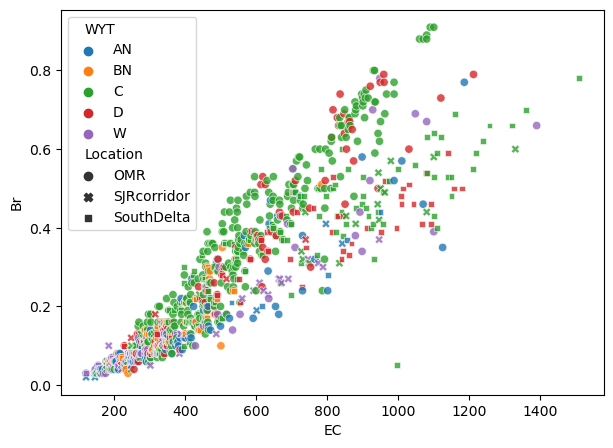

In [43]:
plt.figure(figsize=(7, 5), dpi=100)
sns.scatterplot(x='EC', y=Ion, data=df, hue='WYT', style='Location', alpha=0.8)

<AxesSubplot:xlabel='Location', ylabel='count'>

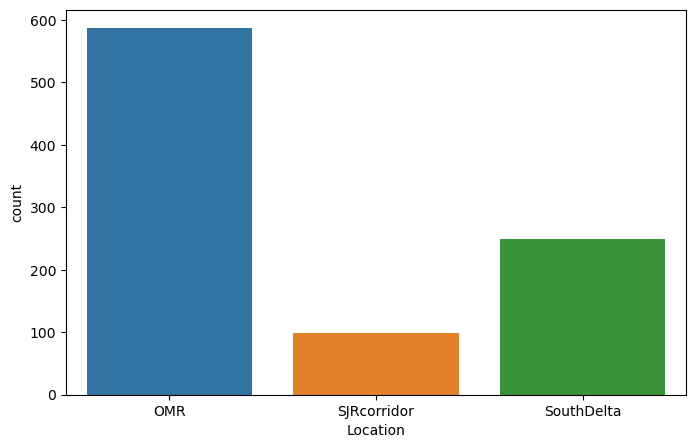

In [44]:
plt.figure(figsize=(8, 5), dpi=100)
sns.countplot(data=df, x='Location')

<AxesSubplot:xlabel='WYT', ylabel='count'>

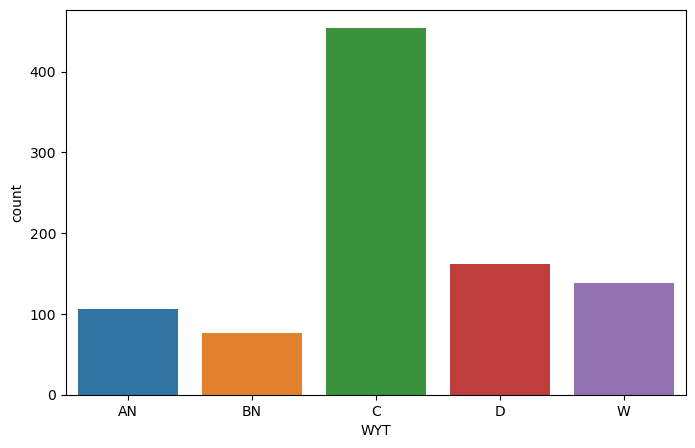

In [45]:
plt.figure(figsize=(8, 5), dpi=100)
sns.countplot(data=df, x='WYT')

<AxesSubplot:xlabel='WYT', ylabel='Br'>

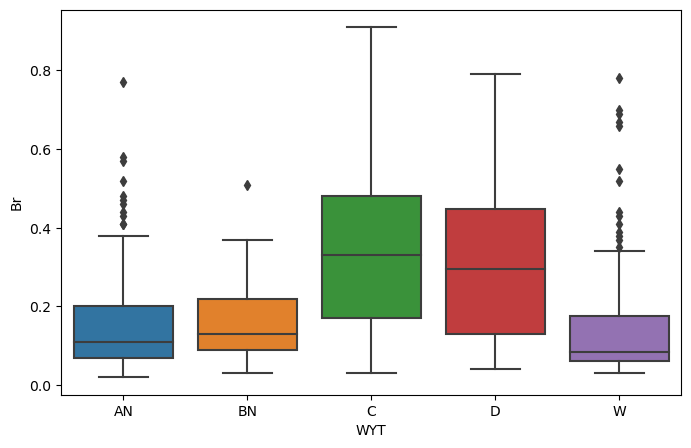

In [46]:
plt.figure(figsize=(8, 5), dpi=100)
sns.boxplot(data=df, y=Ion, x='WYT')

<AxesSubplot:xlabel='WYT', ylabel='EC'>

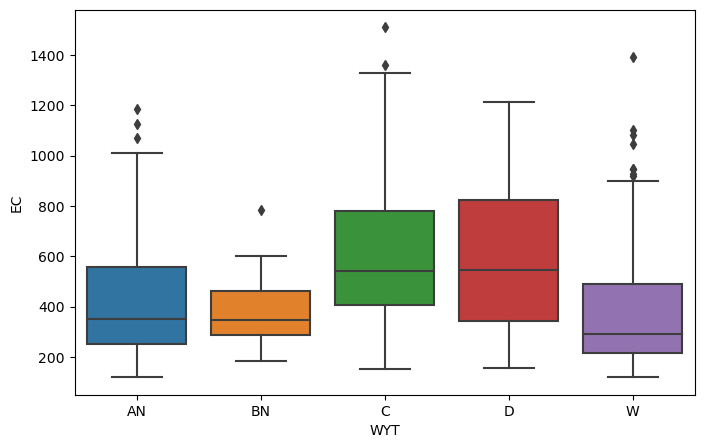

In [47]:
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=df,y='EC', x='WYT')

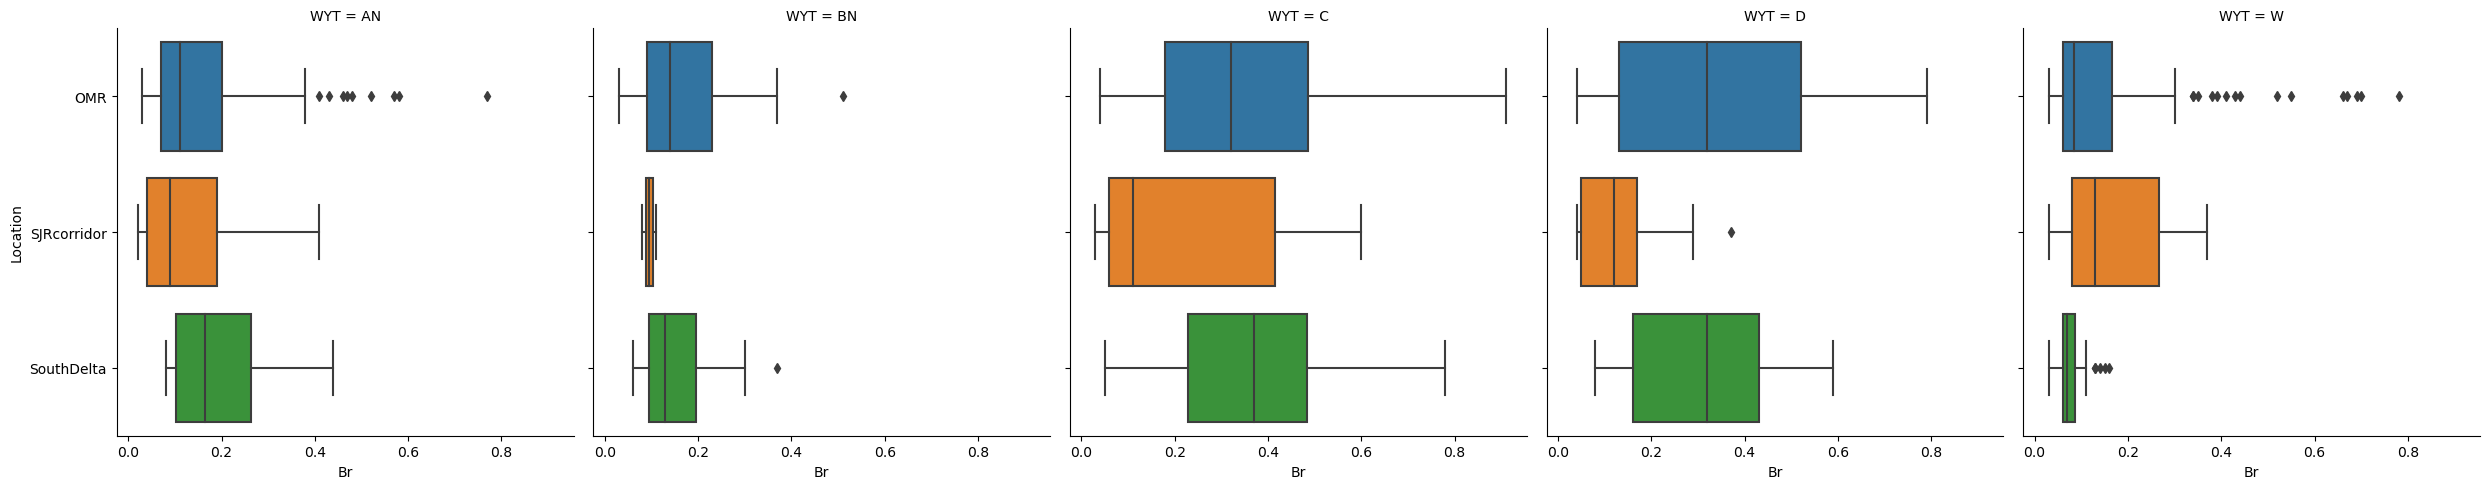

In [48]:
sns.catplot(data=df, x=Ion, y='Location', kind='box', col= 'WYT')

# 4. Splitting the dataset into the Training set and Test set
### &
## Feature Scaling

### In this study, Training and Test datasets were randomly selected (20% Test & 80% Training)

In [49]:
from sklearn.model_selection import train_test_split
df = df2
X = df.drop(Ion, axis=1)
y = df[Ion]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=92)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range = (0, 1))
# # from sklearn.preprocessing import StandardScaler
# # scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(748, 19)
(748,)
(188, 19)
(188,)


# 5. ML algorithms
### 1- Multiple Linear Regression (MLR), 2- Regression Trees (RT), 3- Random Forest (RF), 4- Gradient Boosting (GB), 5- AdaBoost (AB), 6- Artificial Neural Networks (ANN)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

regressorLinear = LinearRegression()
regressorTree = DecisionTreeRegressor(random_state=0)
regressorRF = RandomForestRegressor(n_estimators=500, random_state=0)
regressorGB = GradientBoostingRegressor()
regressorAB = AdaBoostRegressor()

print(Ion)

regressorLinear.fit(X_train, y_train)
y_pred_test = regressorLinear.predict(X_test)
y_pred_train = regressorLinear.predict(X_train)
y_pred_LR = regressorLinear.predict(X)
y_pred_test_LR = regressorLinear.predict(X_test)
print("LinearRegression:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))

print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_LR), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_LR), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_LR), ndigits=2))

print("        ")


regressorTree.fit(X_train, y_train)
y_pred_test = regressorTree.predict(X_test)
y_pred_train = regressorTree.predict(X_train)
y_pred_RT = regressorTree.predict(X)
y_pred_test_RT = regressorTree.predict(X_test)
print("DecisionTreeRegressor:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_RT), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_RT), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_RT), ndigits=2))
print("        ")

regressorRF.fit(X_train, y_train)
y_pred_test = regressorRF.predict(X_test)
y_pred_train = regressorRF.predict(X_train)
y_pred_RF = regressorRF.predict(X)
y_pred_test_RF = regressorRF.predict(X_test)
print("Random Forest:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_RF), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_RF), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_RF), ndigits=2))
print("        ")

regressorGB.fit(X_train, y_train)
y_pred_test = regressorGB.predict(X_test)
y_pred_train = regressorGB.predict(X_train)
y_pred_GB = regressorGB.predict(X)
y_pred_test_GB = regressorGB.predict(X_test)
print("GradientBoosting:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_GB), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_GB), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_GB), ndigits=2))
print("        ")

regressorAB.fit(X_train, y_train)
y_pred_test = regressorAB.predict(X_test)
y_pred_train = regressorAB.predict(X_train)
y_pred_AB = regressorAB.predict(X)
y_pred_test_AB = regressorAB.predict(X_test)
print("Adaboost:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_AB), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_AB), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_AB), ndigits=2))
print("        ")

Br
LinearRegression:
         Training R2 = 0.87   MAE = 0.05   MSE = 0.01
         Test     R2 = 0.89   MAE = 0.05   MSE = 0.0
         All     R2 = 0.88   MAE = 0.05   MSE = 0.0
        
DecisionTreeRegressor:
         Training R2 = 1.0   MAE = 0.0   MSE = 0.0
         Test     R2 = 0.9   MAE = 0.03   MSE = 0.0
         All     R2 = 0.98   MAE = 0.01   MSE = 0.0
        
Random Forest:
         Training R2 = 0.99   MAE = 0.01   MSE = 0.0
         Test     R2 = 0.95   MAE = 0.03   MSE = 0.0
         All     R2 = 0.98   MAE = 0.02   MSE = 0.0
        
GradientBoosting:
         Training R2 = 0.97   MAE = 0.03   MSE = 0.0
         Test     R2 = 0.95   MAE = 0.03   MSE = 0.0
         All     R2 = 0.97   MAE = 0.03   MSE = 0.0
        
Adaboost:
         Training R2 = 0.91   MAE = 0.05   MSE = 0.0
         Test     R2 = 0.91   MAE = 0.04   MSE = 0.0
         All     R2 = 0.91   MAE = 0.05   MSE = 0.0
        


In [51]:
df['LR'] = y_pred_LR
df['RT'] = y_pred_RT
df['RF'] = y_pred_RF
df['GB'] = y_pred_GB
df['AB'] = y_pred_AB

# ANN

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=86)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [53]:
X_train.shape

(748, 19)

In [54]:
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=19, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=25, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=25, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=15, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=5, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer=keras.optimizers.Adamax(
    learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = ann.fit(X_train, y_train, validation_split=0.33,
                  batch_size=16, epochs=200)

y_pred_test = ann.predict(X_test)
y_pred_train = ann.predict(X_train)


print(Ion, "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(mean_absolute_error(
    y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print(Ion, "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2),  "  MAE =", round(mean_absolute_error(
    y_test, y_pred_test), ndigits=2),  "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))

Epoch 1/200
32/32 [==============================] - 1s 6ms/step - loss: 0.0695 - accuracy: 0.0000e+00 - val_loss: 0.0321 - val_accuracy: 0.0000e+00
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.0000e+00 - val_loss: 0.0224 - val_accuracy: 0.0000e+00
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0142 - val_accuracy: 0.0000e+00
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0105 - val_accuracy: 0.0000e+00
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - v

In [55]:
y_pred_ANN = ann.predict(X)
df['ANN'] = y_pred_ANN

30/30 [==============================] - 0s 759us/step


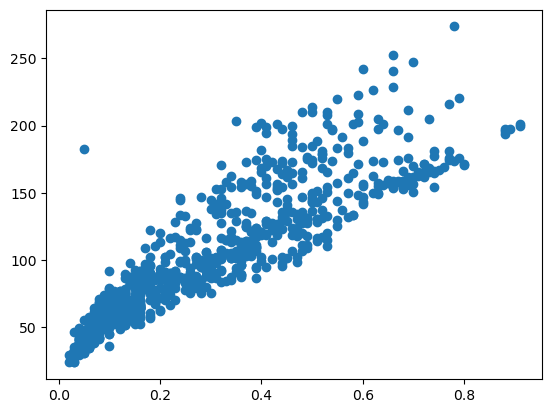

In [56]:
plt.scatter(x=y, y=y_pred_ANN)

In [42]:
Alk_path = "inputs/Alkalinity.csv"
Br_path = "inputs/Br.csv"
Ca_path = "inputs/Ca.csv"
Cl_path = "inputs/Cl.csv"
K_path = "inputs/K.csv"
Mg_path = "inputs/Mg.csv"
Na_path = "inputs/Na.csv"
SO4_path = "inputs/SO4.csv"
TDS_path = "inputs/TDS.csv"

Ion = 'Br'

dfANN = pd.read_csv(Br_path)
dfANN = pd.DataFrame(dfANN)
dfANN["Collection Date"] = pd.to_datetime(dfANN["Collection Date"])
dfANN["Long Station Name"] = dfANN["Long Station Name"].astype("category")
dfANN["Location"] = dfANN["Location"].astype("category")
dfANN["Area"] = dfANN["Area"].astype("category")
# dfANN.dropna(subset=["Sacramento X2"], inplace=True)
dfANN["month"] = dfANN["Collection Date"].dt.month_name()
dfANN["month"] = dfANN["month"].astype("category")
dfANN["WYT"] = dfANN["WYT"].astype("category")
dfANN["EC"] = dfANN["EC"].astype("float64")
dfANN[Ion] = dfANN[Ion].astype("float64")


In [43]:
# X = dfANN.loc[:, ['EC', 'Sacramento X2','WYT','Location','month']]
# y = dfANN.iloc[:, 3]

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder()
feature_array = ohe.fit_transform(dfANN[['WYT','Location','month']]).toarray()
feature_labels = ohe.categories_
feature_labels = np.concatenate((feature_labels[0], feature_labels[1],feature_labels[2]))
XD = pd.DataFrame(feature_array,columns=feature_labels)
dfmerged=pd.merge(dfANN,XD, left_index=True, right_index=True)
dfmerged.dropna(subset=["Sacramento X2"], inplace=True)


In [48]:
dfmerged.columns

Index(['Long Station Name', 'Collection Date', 'EC', 'Br', 'Sacramento X2',
       'WYT', 'Location', 'Area', 'month', 'AN', 'BN', 'C', 'D', 'W', 'OMR',
       'SJRcorridor', 'SouthDelta', 'April', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September'],
      dtype='object')

In [61]:
X = dfmerged.loc[:, ['EC', 'Sacramento X2', 'AN', 'BN', 'C', 'D', 'W', 'OMR','SJRcorridor', 'SouthDelta', 'April', 'August', 'December', 'February','January', 'July', 'June', 'March', 'May', 'November', 'October','September']].values
y=dfmerged.iloc[:, 3].values

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=86)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

In [52]:
print('dfANN.shape=',dfANN.shape)
print('dfmerged.shape=',dfmerged.shape)
print('X.shape=',X.shape)
print('XD.shape=',XD.shape)
print('X_Train.shape=',X_train.shape)
print('y_Train.shape=',y_train.shape)
print('X_Test.shape=',X_test.shape)
print('y_Test.shape=',y_test.shape)

dfANN.shape= (948, 9)
dfmerged.shape= (936, 29)
X.shape= (936, 22)
XD.shape= (948, 20)
X_Train.shape= (748, 22)
y_Train.shape= (748,)
X_Test.shape= (188, 22)
y_Test.shape= (188,)


In [55]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=22, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=30, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=30, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=30, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=30, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer=keras.optimizers.Adamax(
    learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = ann.fit(X_train, y_train, validation_split=0.33,
                  batch_size=16, epochs=200)

y_pred_test = ann.predict(X_test)
y_pred_train = ann.predict(X_train)


print(Ion, "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(mean_absolute_error(
    y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print(Ion, "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2),  "  MAE =", round(mean_absolute_error(
    y_test, y_pred_test), ndigits=2),  "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))

Epoch 1/200
32/32 [==============================] - 1s 7ms/step - loss: 0.1573 - accuracy: 0.0000e+00 - val_loss: 0.0356 - val_accuracy: 0.0000e+00
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.0000e+00 - val_loss: 0.0219 - val_accuracy: 0.0000e+00
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.0155 - accuracy: 0.0000e+00 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0105 - val_accuracy: 0.0000e+00
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - v

30/30 [==============================] - 0s 868us/step


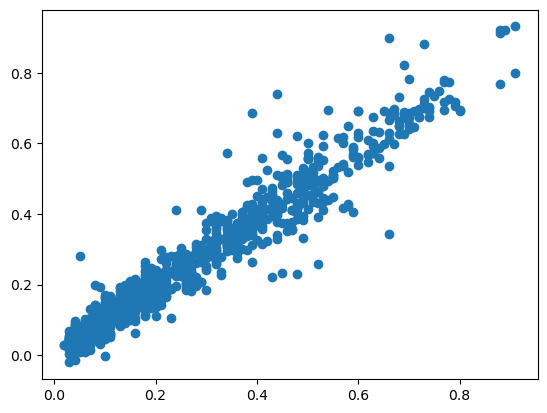

In [62]:
y_pred_ANN = ann.predict(X)
dfmerged['ANN'] = y_pred_ANN
plt.scatter(x=dfmerged[Ion], y=dfmerged['ANN'])

In [60]:
dfmerged

,Long Station Name,Collection Date,EC,Br,Sacramento X2,WYT,Location,Area,month,AN,...,February,January,July,June,March,May,November,October,September,ANN
0,Middle River @ Union Point - P10A,2017-05-03,120.0,0.03,50.006696,W,OMR,Interior,May,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.228192
1,Little Connection Sl. @ Empire Tr.,1993-07-08,120.0,0.02,75.053810,AN,SJRcorridor,Interior,July,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.619342
2,Middle River @ Union Point - P10A,2017-05-03,120.0,0.03,50.006696,W,SouthDelta,Interior,May,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.201197
3,San Joaquin River @ Mossdale Bridge - C7A,1995-05-18,143.0,0.03,50.951562,W,SJRcorridor,Interior,May,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-4.070201
4,Little Connection Sl. @ Empire Tr.,1993-04-21,145.0,0.02,62.383474,AN,SJRcorridor,Interior,April,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.203909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,Old River nr Tracy,1991-01-29,1320.0,0.66,94.905998,C,SouthDelta,Interior,January,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-50.290314
944,San Joaquin River @ Mossdale Bridge - C7A,1991-04-23,1330.0,0.60,85.013628,C,SJRcorridor,Interior,April,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-50.585327
945,Grant Ln Can @ Tracy Rd Bdg,1991-04-23,1360.0,0.70,85.013628,C,SouthDelta,Interior,April,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-51.783356
946,Contra Costa PP Number 01,1999-12-07,1390.0,0.66,84.348624,W,OMR,Interior,December,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-52.786163
